# Activity: Linear Discriminant Analysis (LDA) using SVD
In this activity, we'll use Linear Discriminant Analysis (LDA) to build a supervised low-dimensional representation of a heart disease dataset. Unlike PCA, LDA explicitly uses class labels to find directions that separate classes, and we'll compute those directions using singular value decomposition (SVD).

> __Learning Objectives:__
> 
> By the end of this activity, you should be able to:
> 
> * __Compute class statistics and scatter matrices from clinical data:__ Build within-class and between-class scatter matrices using labeled patient data.
> * __Use SVD to solve the LDA optimization problem:__ Convert the generalized eigenvalue problem into a standard eigenvalue problem via SVD-based whitening.
> * __Project and interpret class separation in a reduced space:__ Visualize LDA projections and assess class separation for the `death_event` label.


Let's get started!

___


## Review: Supervised Dimensionality Reduction with LDA
Suppose we have a labeled dataset $\mathcal{D} = \{(\mathbf{x}_{i}, y_{i})\}_{i=1}^{n}$ where $\mathbf{x}_{i}\in\mathbb{R}^{m}$ is a feature vector and $y_{i}\in\{-1,1\}$ is a binary class label. Partition the data into two classes: $\mathcal{D}_{+} = \{\mathbf{x}_{i} : y_{i}=1\}$ with $n_{+}$ samples, and $\mathcal{D}_{-} = \{\mathbf{x}_{i} : y_{i}=-1\}$ with $n_{-}$ samples. LDA seeks a projection direction $\mathbf{w}$ that maximizes separation between classes while minimizing spread within each class.

A [detailed derivation of LDA](CHEME-5820-L3d-Method-Derivation-LDA-Spring-2026.ipynb) leads to the following optimization problem:

> __Scatter matrices and class statistics:__ We compute class-specific means and the overall mean:
> $$
> \mathbf{m}_{+} = \frac{1}{n_{+}}\sum_{\mathbf{x}_{i}\in\mathcal{D}_{+}} \mathbf{x}_{i}, \quad \mathbf{m}_{-} = \frac{1}{n_{-}}\sum_{\mathbf{x}_{i}\in\mathcal{D}_{-}} \mathbf{x}_{i}, \quad \mathbf{m} = \frac{1}{n}\sum_{i=1}^{n} \mathbf{x}_{i}
> $$
> 
> The **within-class scatter matrix** measures variation within each class:
> $$
> \mathbf{S}_{w} = \sum_{\mathbf{x}_{i}\in\mathcal{D}_{+}}(\mathbf{x}_{i}-\mathbf{m}_{+})(\mathbf{x}_{i}-\mathbf{m}_{+})^{\top} + \sum_{\mathbf{x}_{i}\in\mathcal{D}_{-}}(\mathbf{x}_{i}-\mathbf{m}_{-})(\mathbf{x}_{i}-\mathbf{m}_{-})^{\top}
> $$
> 
> The **between-class scatter matrix** measures separation between class means:
> $$
> \mathbf{S}_{b} = n_{+}(\mathbf{m}_{+}-\mathbf{m})(\mathbf{m}_{+}-\mathbf{m})^{\top} + n_{-}(\mathbf{m}_{-}-\mathbf{m})(\mathbf{m}_{-}-\mathbf{m})^{\top}
> $$
> 
> Both matrices are symmetric and positive semi-definite. In practice, $\mathbf{S}_{w}$ can be singular (e.g., when $m > n$ or the class-centered data are low-rank), so we avoid explicit inversion and instead use an SVD-based whitening transform with a pseudoinverse.

With these scatter matrices in hand, we now formulate the optimization criterion:

> __Fisher criterion and the normalization constraint:__ LDA chooses $\mathbf{w}$ to maximize the ratio of between-class scatter to within-class scatter:
> $$
> J(\mathbf{w}) = \frac{\mathbf{w}^{\top}\mathbf{S}_{b}\,\mathbf{w}}{\mathbf{w}^{\top}\mathbf{S}_{w}\,\mathbf{w}}
> $$
> 
> A key observation is that $J(\mathbf{w})$ is **scale-invariant**: if $\mathbf{w}$ maximizes $J$, so does $c\mathbf{w}$ for any $c \neq 0$. Therefore, we impose the normalization constraint $\mathbf{w}^{\top}\mathbf{S}_{w}\,\mathbf{w} = 1$. Under this constraint, maximizing $J(\mathbf{w})$ is equivalent to maximizing $\mathbf{w}^{\top}\mathbf{S}_{b}\,\mathbf{w}$.

To find the direction that maximizes the criterion under this constraint, we turn to the theory of Lagrange multipliers:

> __The generalized eigenvalue problem:__ Using Lagrange multipliers, the optimal $\mathbf{w}$ satisfies:
> $$
> \mathbf{S}_{b}\,\mathbf{w} = \lambda\,\mathbf{S}_{w}\,\mathbf{w}
> $$
> where $\mathbf{w}\in\mathbb{R}^{m}$ is the projection direction, and $\lambda$ is the generalized eigenvalue. **Critically, at the optimum, the generalized eigenvalue equals the maximum Fisher criterion value:** $\lambda_{\max} = J(\mathbf{w}_{\max})$. We select the direction corresponding to the **largest generalized eigenvalue** $\lambda_{\max}$, which gives the maximum class separation.

Because this lab follows a lecture on SVD, we solve this generalized eigenvalue problem using SVD-based whitening rather than explicit matrix inversion, which is more numerically stable when $\mathbf{S}_{w}$ is ill-conditioned.

> __TL;DR.__ LDA maximizes the Fisher criterion subject to a normalization constraint, yielding a generalized eigenvalue problem. The optimal projection direction is the generalized eigenvector corresponding to the largest eigenvalue, and SVD provides a numerically stable computational method.

___


## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

__Instructions:__ Uncomment the code below to include `Include.jl` and set up the environment.


In [1]:
#=
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file
=#

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.


### Data
Next, let's load up the dataset that we will explore. The data for this lab was taken from this `2020` publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of 299 heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains 13 features (a mixture of continuous and categorical data), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` if the patient did not die during the follow-up period.

We'll load this dataset as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:

__Instructions:__ Uncomment the code below to load the heart disease dataset into `originaldataset`.


In [2]:
#=
originaldataset = MyHeartDiseaseClinicalDataset(); # load the heart disease dataset
=#

#### Data scaling
LDA requires [a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}), not [a `DataFrame`](https://dataframes.juliadata.org/stable/). We preprocess the data in three steps:

> __Data Preprocessing:__
> 
> * __Binary recoding:__ Convert categorical `0,1` data to `-1,1` where `0` maps to `-1` and `1` remains `1`.
> * __Z-score normalization:__ Apply [z-score scaling](https://en.wikipedia.org/wiki/Feature_scaling) to continuous features using $x^{\prime} = (x - \mu)/\sigma$ where $\mu$ is the mean and $\sigma$ is the standard deviation.
> * __Label retention:__ Keep the `death_event` label because LDA is supervised.

The preprocessed feature matrix is stored in `X::Matrix{Float64}`, while the label vector is stored in `y::Vector{Float64}`. We also keep the treated dataset in `dataset::DataFrame`.

__Instructions:__ Uncomment the code below to preprocess the data and create `X`, `y`, and `dataset`.


In [3]:
#=
(X, y, dataset) = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix from the DataFrame
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_z_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_z_scale)
        j = index_to_z_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ;
        end
    end

    # split features and labels
    X = D̂[:,1:end-1]; # features
    y = D̂[:,end]; # labels (death_event)

    X, y, treated_dataset
end;
=#

__Inspect the data__: Take a quick look at the preprocessed feature matrix.

__Instructions:__ Uncomment the code below to display `X`.


In [4]:
#=
X
=#

299×12 Matrix{Float64}:
  1.19095    -1.0   0.000165451  -1.0  …  -1.50152     1.0  -1.0  -1.62678
 -0.490457   -1.0   7.50206      -1.0     -0.141739    1.0  -1.0  -1.60101
  0.350246   -1.0  -0.449186     -1.0     -1.72815     1.0   1.0  -1.58812
 -0.910808    1.0  -0.485257     -1.0      0.0848915   1.0  -1.0  -1.58812
  0.350246    1.0  -0.434757      1.0     -4.67434    -1.0  -1.0  -1.57524
  2.452       1.0  -0.551217     -1.0  …  -1.04826     1.0   1.0  -1.57524
  1.19095     1.0  -0.346124     -1.0      0.0848915   1.0  -1.0  -1.54947
 -0.0701056   1.0  -0.275011      1.0     -1.27489     1.0   1.0  -1.54947
  0.350246   -1.0  -0.437849     -1.0      0.311522   -1.0  -1.0  -1.54947
  1.6113      1.0  -0.47289      -1.0     -0.821629    1.0   1.0  -1.54947
  ⋮                                    ⋱                     ⋮    
 -1.33116    -1.0   0.034176      1.0  …   0.991412   -1.0  -1.0   1.63294
 -0.0701056  -1.0  -0.269858     -1.0      0.538152    1.0  -1.0   1.64582
 -0.74266

___


## Task 1: Compute Class Statistics and Scatter Matrices
In this task, we'll compute the class means and the scatter matrices used in LDA. We need two types of means: the class-specific mean for each label, and the overall mean across all samples. These means help us measure how spread out each class is internally (within-class scatter) and how far apart the classes are from each other (between-class scatter).

> __Class statistics and scatter matrices:__
>
> First, we compute the class mean $\mathbf{m}_{c}$ for each class and the overall mean $\mathbf{m}$:
> $$
> \mathbf{m}_{c} = \frac{1}{n_{c}}\sum_{i:y_{i}=c} \mathbf{x}_{i}, \qquad \mathbf{m} = \frac{1}{n}\sum_{i=1}^{n} \mathbf{x}_{i}
> $$
> Using these means, we build the within-class scatter matrix $\mathbf{S}_{w}$ (measuring how much data varies within each class) and the between-class scatter matrix $\mathbf{S}_{b}$ (measuring how far apart the class means are):
> $$
> \mathbf{S}_{w} = \sum_{c\in\{-1,1\}}\;\sum_{i:y_{i}=c}(\mathbf{x}_{i}-\mathbf{m}_{c})(\mathbf{x}_{i}-\mathbf{m}_{c})^{\top}
> $$
> $$
> \mathbf{S}_{b} = \sum_{c\in\{-1,1\}} n_{c}(\mathbf{m}_{c}-\mathbf{m})(\mathbf{m}_{c}-\mathbf{m})^{\top}
> $$
> where $c\in\{-1,1\}$ is the class label, $n_{c}$ is the number of samples in class $c$, $n$ is the total number of samples, $\mathbf{x}_{i}\in\mathbb{R}^{m}$ is the feature vector for sample $i$, and $y_{i}$ is its class label.

Let's compute $\mathbf{S}_{w}$ and $\mathbf{S}_{b}$ from the preprocessed data. We'll store the class indices in `index_pos::Vector{Int}` and `index_neg::Vector{Int}`, the class means in `m_pos::Vector{Float64}` and `m_neg::Vector{Float64}`, the overall mean in `m::Vector{Float64}`, and the scatter matrices in `S_w::Matrix{Float64}` and `S_b::Matrix{Float64}`:

__Instructions:__ Uncomment the code below to compute class indices, means, and the scatter matrices.


In [5]:
#=
(index_pos, index_neg, m, m_pos, m_neg, S_w, S_b) = let

    # split by class
    index_pos = findall(==(1), y);
    index_neg = findall(==(-1), y);
    X_pos = X[index_pos, :];
    X_neg = X[index_neg, :];

    # means
    m = mean(X, dims=1) |> vec;
    m_pos = mean(X_pos, dims=1) |> vec;
    m_neg = mean(X_neg, dims=1) |> vec;

    # within-class scatter
    n_features = size(X,2);
    S_w = zeros(n_features, n_features);
    for i ∈ 1:size(X_pos,1)
        x = vec(X_pos[i, :]) - m_pos;
        S_w += x * x';
    end
    for i ∈ 1:size(X_neg,1)
        x = vec(X_neg[i, :]) - m_neg;
        S_w += x * x';
    end

    # between-class scatter
    n_pos = length(index_pos);
    n_neg = length(index_neg);
    Δ_pos = m_pos - m;
    Δ_neg = m_neg - m;
    S_b = n_pos*(Δ_pos * Δ_pos') + n_neg*(Δ_neg * Δ_neg');

    index_pos, index_neg, m, m_pos, m_neg, S_w, S_b
end;
=#

__Check__: Both scatter matrices should be symmetric. Let's verify this numerically:

__Instructions:__ Uncomment the code below to verify symmetry of `S_w` and `S_b`.


In [6]:
#=
let

    # initialize -
    ϵ = 1e-8;
    test_sw = norm(S_w - S_w', Inf) < ϵ;
    test_sb = norm(S_b - S_b', Inf) < ϵ;

    @assert test_sw "S_w is not symmetric within tolerance!"
    @assert test_sb "S_b is not symmetric within tolerance!"
end
=#

___


## Task 2: Compute the LDA Direction using SVD
Maximizing the Fisher criterion leads to a generalized eigenvalue problem. Rather than inverting matrices directly (which can be numerically unstable), we use SVD-based whitening to convert the problem into a standard eigenvalue problem.

Whitening is a linear transform that rescales data so the covariance becomes the identity matrix. In LDA, we whiten with respect to the within-class scatter matrix $\mathbf{S}_{w}$, which normalizes within-class variation and makes the eigenproblem easier to solve. This also reduces the effect of ill-conditioning when features are correlated or on different scales.

Why do we use the whitening transform from the derivation? The generalized eigenproblem $\mathbf{S}_{b}\mathbf{w} = \lambda\,\mathbf{S}_{w}\mathbf{w}$ is hard to solve directly because $\mathbf{S}_{w}$ may be ill-conditioned or singular. Whitening converts it to a standard eigenvalue problem in a space where the within-class scatter is the identity matrix, and then we map the solution back to the original feature space.

> __Generalized eigenvalue form:__
>
> The LDA direction $\mathbf{w}$ satisfies:
> $$
> \mathbf{S}_{b}\,\mathbf{w} = \lambda\,\mathbf{S}_{w}\,\mathbf{w}
> $$
> where $\mathbf{w}\in\mathbb{R}^{m}$ is the LDA direction, $\lambda$ is the generalized eigenvalue, and $\mathbf{S}_{w}, \mathbf{S}_{b}$ are the within-class and between-class scatter matrices.

To solve this without matrix inversion, we apply the SVD-based whitening from the derivation.

> __Within-class SVD and whitening (derivation notation):__
>
> Define the within-class centered matrix $\mathbf{H}=[\mathbf{x}_1-\mathbf{m}_{y_1},\dots,\mathbf{x}_n-\mathbf{m}_{y_n}]$ so that $\mathbf{S}_{w}=\mathbf{H}\mathbf{H}^{\top}$. The thin SVD $\mathbf{H}=\mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top}$ gives $\mathbf{S}_{w}=\mathbf{U}\mathbf{\Sigma}^2\mathbf{U}^{\top}$. The whitening operator is
> $$
> \mathbf{Z}=\mathbf{\Sigma}^{+}\,\mathbf{U}^{\top}
> $$
> where $\mathbf{\Sigma}^{+}$ is the pseudoinverse (apply a tolerance to ignore tiny singular values). This gives $\mathbf{Z}\,\mathbf{S}_{w}\,\mathbf{Z}^{\top}=\mathbf{I}$.
>
> In whitened coordinates, define $\mathbf{a}$ so that $\mathbf{w}=\mathbf{U}\mathbf{\Sigma}^{+}\mathbf{a}$. Then the generalized eigenvalue problem reduces to the standard eigenproblem:
> $$
> \left(\mathbf{\Sigma}^{+}\mathbf{U}^{\top}\mathbf{S}_{b}\mathbf{U}\mathbf{\Sigma}^{+}\right)\mathbf{a} = \lambda\mathbf{a}.
> $$
> Equivalently, with the between-class mean matrix $\mathbf{M}=[\sqrt{n_1}(\mathbf{m}_1-\mathbf{m}),\dots,\sqrt{n_k}(\mathbf{m}_k-\mathbf{m})]$ and $\mathbf{B}=\mathbf{\Sigma}^{+}\mathbf{U}^{\top}\mathbf{M}$, we solve $\mathbf{B}\mathbf{B}^{\top}\mathbf{a}=\lambda\mathbf{a}$ and map back via $\mathbf{w}=\mathbf{U}\mathbf{\Sigma}^{+}\mathbf{a}$ (then normalize).

We'll compute the dominant eigenvector of the whitened matrix using SVD and map it back to the original feature space to obtain the LDA direction $\mathbf{w}$.

__Instructions:__ Uncomment the code below to compute the LDA direction `w` and the leading eigenvalue using SVD.


In [7]:
#=
(w, λ̂) = let

    # SVD of within-class scatter
    svd_sw = svd(S_w);
    U = svd_sw.U;
    Σ = svd_sw.S;

    # build S_w^{-1/2} with a small tolerance
    ϵ = 1e-10;
    Σ_inv_sqrt = Diagonal([s > ϵ ? 1/sqrt(s) : 0.0 for s in Σ]);
    S_w_inv_sqrt = U * Σ_inv_sqrt * U';

    # whitened between-class scatter
    M = S_w_inv_sqrt * S_b * S_w_inv_sqrt;

    # dominant direction via SVD
    svd_m = svd(M);
    v₁ = svd_m.U[:,1];
    w = S_w_inv_sqrt * v₁;
    w = w / norm(w); # normalize

    λ = svd_m.S[1];
    w, λ
end;
=#

__Check__: Let's compute the Fisher criterion value for the LDA direction:

__Instructions:__ Uncomment the code below to compute the Fisher criterion for `w`.


In [8]:
#=
let

    numerator = (w' * S_b * w)[1];
    denominator = (w' * S_w * w)[1];
    J = numerator/denominator;

    println("Fisher criterion J(w) = $(round(J, digits=4))")
end
=#

Fisher criterion J(w) = 0.7148


___


## Task 3: Visualize the LDA Projection
Because this dataset has two classes, LDA produces a single discriminant direction. We'll project each data point onto $\mathbf{w}$ and visualize the class separation along that axis. By centering the data first (subtracting the overall mean), we ensure the projection captures deviations from the average, which makes class separation clearer.

> __LDA projection:__
>
> For each sample, we compute the scalar LDA score and store all scores in the `Z::Vector{Float64}` variable:
> $$
> z_{i} = (\mathbf{x}_{i}-\mathbf{m})^{\top}\mathbf{w}
> $$
> where $z_{i}$ is the LDA score for sample $i$, $\mathbf{x}_{i}$ is the feature vector, $\mathbf{m}$ is the overall mean vector, and $\mathbf{w}$ is the LDA direction.

Let's compute the projection scores now.

__Instructions:__ Uncomment the code below to compute the LDA projection scores `Z`.


In [9]:
#=
Z = let

    # center the data
    X_centered = X .- (ones(size(X,1)) * m');
    Z = X_centered * w; # projected scores
    Z
end;
=#

__Visualize__: We'll plot the projected scores for each class and mark the midpoint between class means.

__Instructions:__ Uncomment the code below to plot the 1D LDA histogram and midpoint threshold.


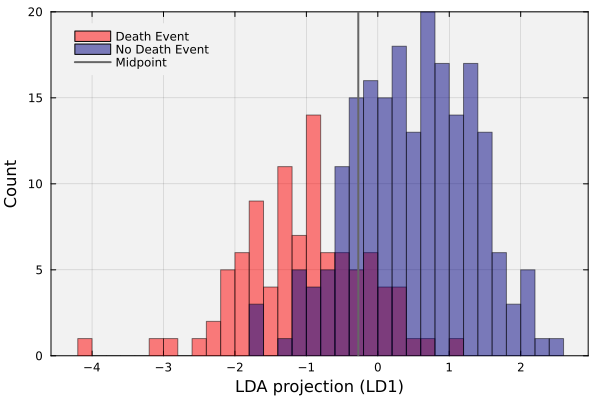

In [10]:
#=
let

    # projected scores by class
    Z_pos = Z[index_pos];
    Z_neg = Z[index_neg];

    # class means in LDA space
    μ_pos = mean(Z_pos);
    μ_neg = mean(Z_neg);
    τ = (μ_pos + μ_neg)/2; # midpoint

    # visualize
    death_color = :red;
    survival_color = :navy;
    histogram(Z_pos; bins=30, alpha=0.5, color=death_color, label="Death Event")
    histogram!(Z_neg; bins=30, alpha=0.5, color=survival_color, label="No Death Event")
    vline!([τ], c=:gray40, lw=2, label="Midpoint")

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("LDA projection (LD1)", fontsize=18)
    ylabel!("Count", fontsize=18)
end

=#

__Visualize (2D LDA):__ For comparison with the PCA plot, we can visualize the first two LDA directions in a 2D scatter plot. For two-class LDA, only one discriminant direction carries class separation; the second direction typically captures little additional separation, but it provides a consistent 2D view.

> __2D LDA projection:__
> $$
> \mathbf{Y} = (\mathbf{X} - \mathbf{1}\,\mathbf{m}^{\top})\,\mathbf{W}
> $$
> where:
> * $\mathbf{X}\in\mathbb{R}^{n\times m}$ is the feature matrix.
> * $\mathbf{1}\in\mathbb{R}^{n}$ is the vector of ones.
> * $\mathbf{m}\in\mathbb{R}^{m}$ is the overall mean vector.
> * $\mathbf{W}\in\mathbb{R}^{m\times 2}$ contains the first two LDA directions.
> * $\mathbf{Y}\in\mathbb{R}^{n\times 2}$ contains the 2D LDA scores.

__Instructions:__ Uncomment the code below to plot the 2D LDA projection.


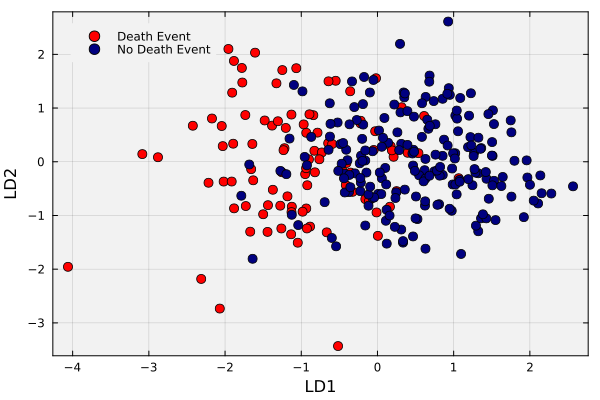

In [11]:
#=
let

    # recompute whitening operator and LDA directions
    svd_sw = svd(S_w);
    U = svd_sw.U;
    Σ = svd_sw.S;

    ϵ = 1e-10;
    Σ_inv_sqrt = Diagonal([s > ϵ ? 1/sqrt(s) : 0.0 for s in Σ]);
    S_w_inv_sqrt = U * Σ_inv_sqrt * U';

    M = S_w_inv_sqrt * S_b * S_w_inv_sqrt;
    svd_m = svd(M);
    W = S_w_inv_sqrt * svd_m.U[:,1:2];

    # normalize columns for visualization
    W[:,1] = W[:,1] / norm(W[:,1]);
    W[:,2] = W[:,2] / norm(W[:,2]);

    # project to 2D
    X_centered = X .- (ones(size(X,1)) * m');
    Y = X_centered * W;

    # color by class
    death_color = :red;
    survival_color = :navy;
    y_pos = findall(==(1), y);
    y_neg = findall(==(-1), y);

    scatter([Y[y_pos,1]], [Y[y_pos,2]]; color=death_color, label="Death Event", markersize=5)
    scatter!([Y[y_neg,1]], [Y[y_neg,2]]; color=survival_color, label="No Death Event", markersize=5)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("LD1", fontsize=18)
    ylabel!("LD2", fontsize=18)
end

=#

__What do you observe?__

Because LDA explicitly uses class labels, the projection typically shows clearer separation than PCA. In this heart disease dataset, the two classes shift apart along the discriminant axis, but some overlap remains because the clinical features are not perfectly separable.

> __Interpretation__: The midpoint line provides a simple visual threshold that highlights where misclassifications are most likely to occur. LDA maximizes class separation in a low-dimensional space, but real clinical data often exhibit overlap due to noise, confounding factors, and feature correlations.

__Performance__: We'll classify each sample by thresholding the LDA score at the midpoint between class means, then compute a confusion matrix. The results are stored in `CM_lda::Matrix{Int}` (the confusion matrix) and `ŷ_lda::Vector{Int}` (the predicted labels).

__Instructions:__ Uncomment the code below to compute predicted labels and the confusion matrix.


In [12]:
#=
(CM_lda, ŷ_lda) = let

    # recompute midpoint threshold in LDA space
    Z_pos = Z[index_pos];
    Z_neg = Z[index_neg];
    μ_pos = mean(Z_pos);
    μ_neg = mean(Z_neg);
    τ = (μ_pos + μ_neg)/2;

    # assign labels using the midpoint (sign-invariant to w direction)
    ŷ = [abs(z - μ_pos) <= abs(z - μ_neg) ? 1 : -1 for z ∈ Z];

    # confusion matrix
    CM = confusion(Int.(y), Int.(ŷ));
    CM, ŷ
end;
=#

__Instructions:__ Uncomment the code below to compute the fraction of correct and incorrect predictions.


In [13]:
#=
let

    number_of_examples = length(y);
    correct_predictions = CM_lda[1,1] + CM_lda[2,2];
    (correct_predictions/number_of_examples) |> f -> println("Fraction correct: $(f) Fraction incorrect $(1-f)")
end
=#

Fraction correct: 0.8127090301003345 Fraction incorrect 0.18729096989966554


___


## Summary
This activity applied Linear Discriminant Analysis to a heart disease dataset and used SVD-based whitening to compute the discriminant direction.

> __Key Takeaways:__
> 
> * **LDA is supervised dimensionality reduction:** It uses class labels to find directions that maximize between-class variance while minimizing within-class variance.
> * **SVD provides a stable route to LDA solutions:** Whitening the within-class scatter matrix with SVD converts the generalized eigenvalue problem into a standard eigenvalue problem.
> * **LDA projections reveal class separation:** Even with overlap, the LDA axis exposes the dominant direction that best separates the `death_event` classes.

LDA complements PCA by focusing on class separability rather than variance alone, making it a useful tool when labels are available.

___
